In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

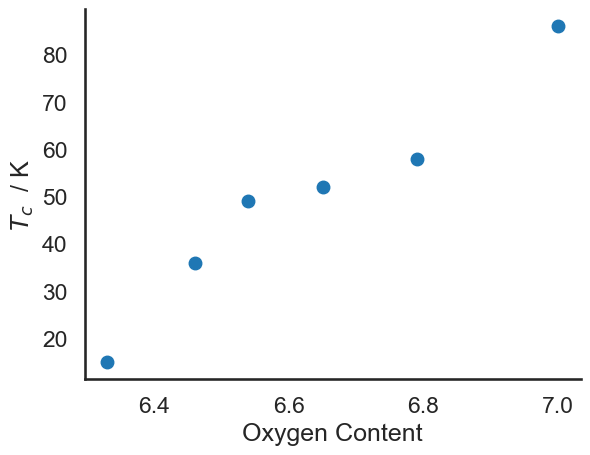

In [2]:
# Set seaborn style and context
sns.set_style("white")
sns.set_context("talk")
sns.color_palette("colorblind")

# Read data
data_YBCO = pd.read_csv('ybco-tc.csv')

# Plot data
plt.plot(data_YBCO["Oxygen_Content"], data_YBCO["Tc (K)"], 'o')
plt.xlabel('Oxygen Content')
plt.ylabel('$\it{T_c}$  / K')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()

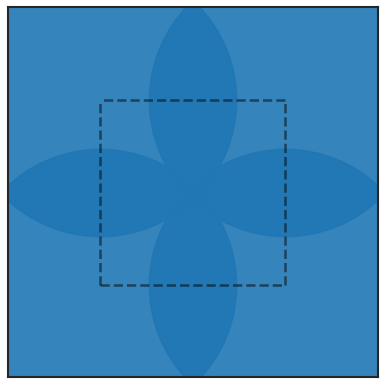

In [3]:
# Define the coordinates
x = [0, 1, 0, 1]
y = [0, 1, 1, 0]

# Create a new figure with equal aspect ratio
plt.figure(figsize=(6, 6), dpi=80)

# Plot the dots
plt.scatter(x, y, s=60000, alpha=0.9)

# Plot the lines
plt.plot([0, 0], [0, 1], color='black', linestyle='--', alpha=0.5)
plt.plot([1, 0], [1, 1], color='black', linestyle='--', alpha=0.5)
plt.plot([1, 1], [0, 1], color='black', linestyle='--', alpha=0.5)
plt.plot([0, 1], [0, 0], color='black', linestyle='--', alpha=0.5)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

# Remove the axis ticks
plt.xticks([])
plt.yticks([])

# Show the plot
plt.show()

In [4]:
from bokeh.models import (
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    ColorBar,
    BasicTicker,
)
from bokeh.plotting import figure, output_file
from bokeh.io import output_notebook
from bokeh.io import export_png
from bokeh.io import show as show_
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge
from csv import reader
from matplotlib.colors import Normalize, LogNorm, to_hex
from matplotlib.cm import (
    plasma,
    inferno,
    magma,
    viridis,
    cividis,
    turbo,
    ScalarMappable,
)
from pandas import options
from typing import List
import warnings

def plotter(
    filename: str,
    show: bool = True,
    output_filename: str = None,
    width: int = 1050,
    cmap: str = "plasma",
    alpha: float = 0.65,
    extended: bool = True,
    periods_remove: List[int] = None,
    groups_remove: List[int] = None,
    log_scale: bool = False,
    cbar_height: float = None,
    cbar_standoff: int = 12,
    cbar_fontsize: int = 14,
    blank_color: str = "#c4c4c4",
    under_value: float = None,
    under_color: str = "#140F0E",
    over_value: float = None,
    over_color: str = "#140F0E",
    special_elements: List[str] = None,
    special_color: str = "#6F3023",
) -> figure:

    """
    Plot a heatmap over the periodic table of elements.

    Parameters
    ----------
    filename : str
        Path to the .csv file containing the data to be plotted.
    show : str
        If True, the plot will be shown.
    output_filename : str
        If not None, the plot will be saved to the specified (.html) file.
    width : float
        Width of the plot.
    cmap : str
        plasma, inferno, viridis, magma, cividis, turbo
    alpha : float
        Alpha value (transparency).
    extended : bool
        If True, the lanthanoids and actinoids will be shown.
    periods_remove : List[int]
        Period numbers to be removed from the plot.
    groups_remove : List[int]
        Group numbers to be removed from the plot.
    log_scale : bool
        If True, the colorbar will be logarithmic.
    cbar_height : int
        Height of the colorbar.
    cbar_standoff : int
        Distance between the colorbar and the plot.
    cbar_fontsize : int
        Fontsize of the colorbar label.
    blank_color : str
        Hexadecimal color of the elements without data.
    under_value : float
        Values <= under_value will be colored with under_color.
    under_color : str
        Hexadecimal color to be used for the lower bound color.
    over_value : float
        Values >= over_value will be colored with over_color.
    under_color : str
        Hexadecial color to be used for the upper bound color.
    special_elements: List[str]
        List of elements to be colored with special_color.
    special_color: str
        Hexadecimal color to be used for the special elements.

    Returns
    -------
    figure
        Bokeh figure object.
    """

    options.mode.chained_assignment = None

    # Assign color palette based on input argument
    if cmap == "plasma":
        cmap = plasma
        bokeh_palette = "Plasma256"
    elif cmap == "inferno":
        cmap = inferno
        bokeh_palette = "Inferno256"
    elif cmap == "magma":
        cmap = magma
        bokeh_palette = "Magma256"
    elif cmap == "viridis":
        cmap = viridis
        bokeh_palette = "Viridis256"
    elif cmap == "cividis":
        cmap = cividis
        bokeh_palette = "Cividis256"
    elif cmap == "turbo":
        cmap = turbo
        bokeh_palette = "Turbo256"
    else:
        ValueError("Invalid color map.")

    # Define number of and groups
    period_label = ["1", "2", "3", "4", "5", "6", "7"]
    group_range = [str(x) for x in range(1, 19)]

    # Remove any groups or periods
    if groups_remove:
        for gr in groups_remove:
            gr = gr.strip()
            group_range.remove(str(gr))
    if periods_remove:
        for pr in periods_remove:
            pr = pr.strip()
            period_label.remove(str(pr))

    # Read in data from CSV file
    data_elements = []
    data_list = []
    for row in reader(open(filename)):
        data_elements.append(row[0])
        data_list.append(row[1])
    data = [float(i) for i in data_list]

    if len(data) != len(data_elements):
        raise ValueError("Unequal number of atomic elements and data points")

    period_label.append("blank")
    period_label.append("La")
    period_label.append("Ac")

    if extended:
        count = 0
        for i in range(56, 70):
            elements.period[i] = "La"
            elements.group[i] = str(count + 4)
            count += 1

        count = 0
        for i in range(88, 102):
            elements.period[i] = "Ac"
            elements.group[i] = str(count + 4)
            count += 1

    # Define matplotlib and bokeh color map
    if log_scale:
        for datum in data:
            if datum < 0:
                raise ValueError(
                    f"Entry for element {datum} is negative but log-scale is selected"
                )
        color_mapper = LogColorMapper(
            palette=bokeh_palette, low=min(data), high=max(data)
        )
        norm = LogNorm(vmin=min(data), vmax=max(data))
    else:
        color_mapper = LinearColorMapper(
            palette=bokeh_palette, low=min(data), high=max(data)
        )
        norm = Normalize(vmin=min(data), vmax=max(data))
    color_scale = ScalarMappable(norm=norm, cmap=cmap).to_rgba(data, alpha=None)

    # Set blank color
    color_list = [blank_color] * len(elements)

    # Compare elements in dataset with elements in periodic table
    for i, data_element in enumerate(data_elements):
        element_entry = elements.symbol[
            elements.symbol.str.lower() == data_element.lower()
        ]
        if element_entry.empty == False:
            element_index = element_entry.index[0]
        else:
            warnings.warn("Invalid chemical symbol: " + data_element)
        if color_list[element_index] != blank_color:
            warnings.warn("Multiple entries for element " + data_element)
        elif under_value is not None and data[i] <= under_value:
            color_list[element_index] = under_color
        elif over_value is not None and data[i] >= over_value:
            color_list[element_index] = over_color
        else:
            color_list[element_index] = to_hex(color_scale[i])

    if special_elements:
        for k, v in elements["symbol"].items():
            if v in special_elements:
                color_list[k] = special_color

    # Define figure properties for visualizing data
    source = ColumnDataSource(
        data=dict(
            group=[str(x) for x in elements["group"]],
            period=[str(y) for y in elements["period"]],
            sym=elements["symbol"],
            atomic_number=elements["atomic number"],
            type_color=color_list,
        )
    )

    # Plot the periodic table
    p = figure(x_range=group_range, y_range=list(reversed(period_label)), tools="save")
    p.width = width
    p.outline_line_color = None
    p.background_fill_color = None
    p.border_fill_color = None
    p.toolbar_location = "above"
    p.rect("group", "period", 0.9, 0.9, source=source, alpha=alpha, color="type_color")
    p.axis.visible = False
    text_props = {
        "source": source,
        "angle": 0,
        "color": "black",
        "text_align": "left",
        "text_baseline": "middle",
    }
    x = dodge("group", -0.4, range=p.x_range)
    y = dodge("period", 0.3, range=p.y_range)
    p.text(
        x=x,
        y="period",
        text="sym",
        text_font_style="bold",
        text_font_size="16pt",
        **text_props,
    )
    p.text(x=x, y=y, text="atomic_number", text_font_size="11pt", **text_props)

    color_bar = ColorBar(
        color_mapper=color_mapper,
        ticker=BasicTicker(desired_num_ticks=10),
        border_line_color=None,
        label_standoff=cbar_standoff,
        location=(0, 0),
        orientation="vertical",
        scale_alpha=alpha,
        major_label_text_font_size=f"{cbar_fontsize}pt",
    )

    if cbar_height is not None:
        color_bar.height = cbar_height

    p.add_layout(color_bar, "right")
    p.grid.grid_line_color = None

    if output_filename:
        output_file(output_filename)

    if show:
        show_(p)

    return p

In [6]:
dataset_MP = pd.read_csv("../3DSC_MP.csv", skiprows=1)

import chemparse

x = chemparse.parse_formula(dataset_MP["formula_sc"][0])

for i in range(1, len(dataset_MP["formula_sc"])):
    y = chemparse.parse_formula(dataset_MP["formula_sc"][i])
    x = {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}

print(x["O"])
# Remove 'O' from the dictionary
x.pop('O', None)

element_count = pd.DataFrame.from_dict(x, orient='index', columns=['Count'])
element_count.reset_index(inplace=True)
element_count.rename(columns={'index': 'Element'}, inplace=True)
element_count.sort_values(by='Count', ascending=False, inplace=True)
element_count.reset_index(drop=True, inplace=True)
element_count.to_csv('element_count.csv', index=False, header=False)

fig = plotter('element_count.csv', show=False, cmap='plasma', special_elements=['O'], special_color="#0EDD1E")
output_file('element_count.html')
output_notebook()
show_(fig)

6458.519000000001


C:\Users\Fay\AppData\Local\Temp\ipykernel_22648\3047310221.py:160: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'La' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elements.period[i] = "La"


Loading BokehJS ...

In [7]:
not_doped = dataset_MP[dataset_MP["synth_doped"] == False]
print(len(not_doped))

x = chemparse.parse_formula(not_doped["formula_sc"].iloc[0])

for i in range(1, len(not_doped["formula_sc"])):
    y = chemparse.parse_formula(not_doped["formula_sc"].iloc[i])
    x = {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}
    
print(x["O"])
# Remove 'O' from the dictionary
x.pop('O', None)

element_count = pd.DataFrame.from_dict(x, orient='index', columns=['Count'])
element_count.reset_index(inplace=True)
element_count.rename(columns={'index': 'Element'}, inplace=True)
element_count.sort_values(by='Count', ascending=False, inplace=True)
element_count.reset_index(drop=True, inplace=True)
element_count.to_csv('element_count_2.csv', index=False, header=False)

fig = plotter('element_count_2.csv', show=False, cmap='plasma', special_elements=['O'], special_color="#0EDD1E")
output_file('element_count_2.html')
output_notebook()
show_(fig)

2336
1221.1


Loading BokehJS ...